# Welcome to pyLIMA tutorial! #
Let's learn how pyLIMA works by fitting an example.

To obtain working link to the documentation, you need to :

make html

in the doc directory.

Please help yourself with the [pyLIMA documentation](file/../../doc/build/html/index.html)


In [1]:
### First import the required libraries
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels

Nothing wrong? 
Let's go ahead.

# The event module #
We have to define an [event](file/../../doc/build/html/pyLIMA.event.html) object.

In [2]:
### Create an event object. You can choose the name and RA,DEC in degrees :

your_event = event.Event()
your_event.name = 'your choice'
your_event.ra = 269.39166666666665 
your_event.dec = -29.22083333333333

# The telescopes module#
To insert data to your event, we need to define  [telescopes](file/../../doc/build/html/pyLIMA.telescopes.html) objects and just add it
to the event object telescope list.

In [3]:
### Now we need some observations. That's good, we obtain some data on two
### telescopes. Both are in I band and magnitude units :

data_1 = np.loadtxt('./Survey_1.dat')
telescope_1 = telescopes.Telescope(name='OGLE', camera_filter='I', light_curve_magnitude=data_1)

data_2 = np.loadtxt('./Followup_1.dat')
telescope_2 = telescopes.Telescope(name='LCOGT', camera_filter='I', light_curve_magnitude=data_2)

### Add the telescopes to your event :
your_event.telescopes.append(telescope_1)
your_event.telescopes.append(telescope_2)

### Find the survey telescope :
your_event.find_survey('OGLE')

### Sanity check
your_event.check_event()

check_event  : Everything looks fine, this event can be fitted


# The model module #
We have now to define a [model](file/../../doc/build/html/pyLIMA.microlmodels.html) object that summarizes what kind of model you want to fit.
Let's start with a basic PSPL.

In [4]:
### Construct the model you want to fit. Let's go basic with a PSPL, without second_order effects :
model_1 = microlmodels.create_model('PSPL', your_event)


# We are all set now. Just fit by choosing one method #
For a summary of fitting options, please go [there](file/../../doc/build/html/pyLIMA.microlfits.html)


Start fit on your choice, with model PSPL and method LM
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
lmarquardt  : Levenberg_marquardt fit SUCCESS
[79.96376031656139, 0.011068596898097326, 9.607671858535316, 3153.1207048310876, -0.0075252103496258925, 106079.65049791466, -0.4439970478678547, 8440.1695016247013]


<IPython.core.display.Javascript object>


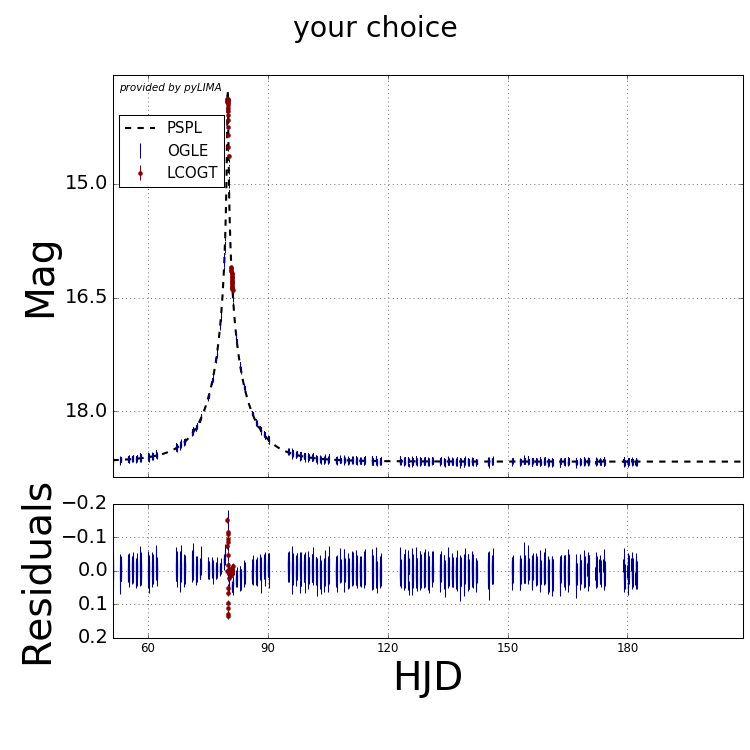

<IPython.core.display.Javascript object>


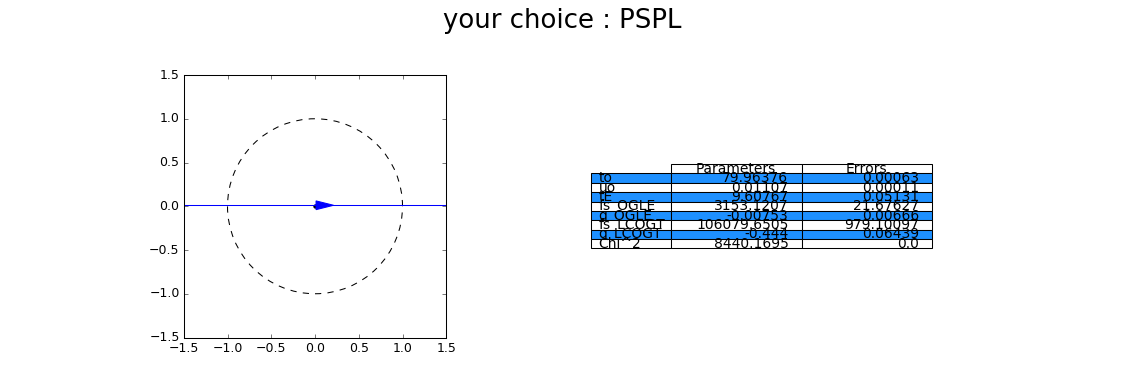

Chi2_LM : 8440.16950162


In [6]:
### Let's try with the simplest Levenvberg_Marquardt algorithm :
your_event.fit(model_1,'LM')

### Let's see some plots.
your_event.fits[0].produce_outputs()
print 'Chi2_LM :',your_event.fits[0].outputs.fit_parameters.chichi
plt.show()


There is some residuals close to the peak, right? And the Chi2 is high also. Maybe the LM algorithm performs poorly, let's try something more powerfull.

You can zoom close to the peak to see what is going on. 


Start fit on your choice, with model PSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1.6855e+06
differential_evolution step 2: f(x)= 1.6855e+06
differential_evolution step 3: f(x)= 1.6732e+06
differential_evolution step 4: f(x)= 1.5917e+06
differential_evolution step 5: f(x)= 1.52184e+06
differential_evolution step 6: f(x)= 1.51849e+06
differential_evolution step 7: f(x)= 1.38871e+06
differential_evolution step 8: f(x)= 1.1089e+06
differential_evolution step 9: f(x)= 1.09418e+06
differential_evolution step 10: f(x)= 1.09418e+06
differential_evolution step 11: f(x)= 1.09418e+06
differential_evolution step 12: f(x)= 953762
differential_evolution step 13: f(x)= 953762
differential_evolution step 14: f(x)= 953762
differential_evolution step 15: f(x)= 953762
differential_evolution step 16: f(x)= 953762
differential_evolution step 17: f(x)= 953762
differential_evolution step 18: f(x)= 953762
differential_evolution step 1

<IPython.core.display.Javascript object>


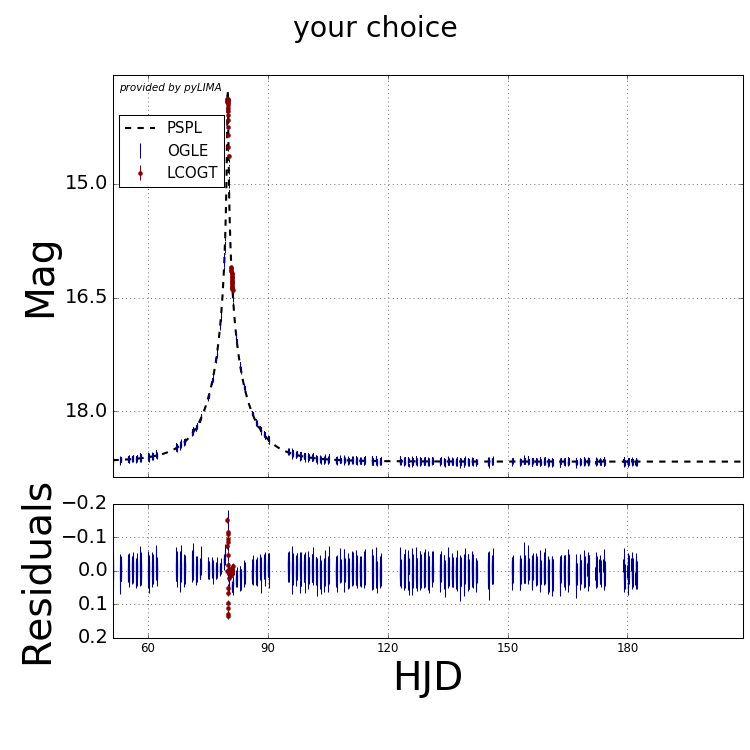

<IPython.core.display.Javascript object>


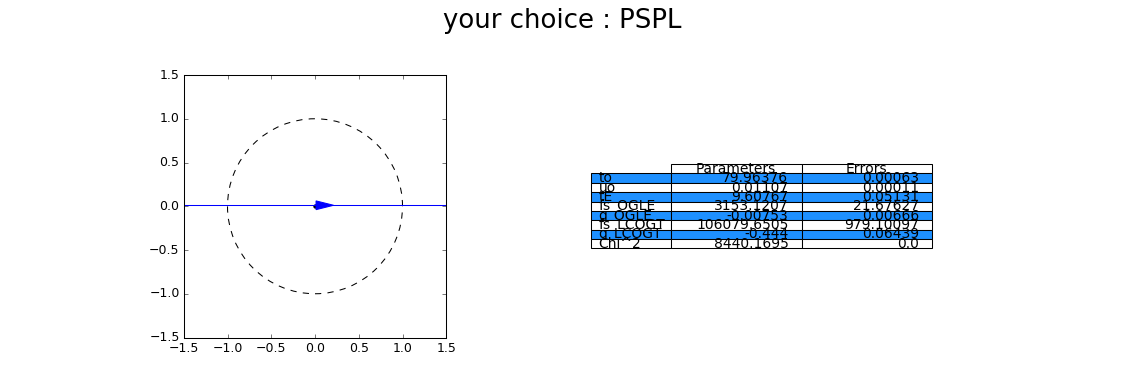

Chi2_DE : 8440.16950162


In [7]:
### Let's try with differential evolution  algorithm. WAIT UNTIL THE FIGURE POP UP.
your_event.fit(model_1,'DE')
your_event.fits[1].produce_outputs()
print 'Chi2_DE :',your_event.fits[1].outputs.fit_parameters.chichi
plt.show()


Well, that's not really better. Maybe there is some other effects in the model?
Let's try an FSPL model!


You can zoom close to the peak to see what is going on.

In [ ]:
### Let's go basic for FSPL :
model_2 = microlmodels.create_model('FSPL', your_event)

your_event.fit(model_2,'LM')

### Let's see some plots. You can zoom close to the peak to see what is going on. 
your_event.fits[-1].produce_outputs()
print 'Chi2_LM :',your_event.fits[-1].outputs.fit_parameters.chichi
plt.show()


That's better, but there is still some deviations around 80.1 days. Any ideas?

...

...

...

What about some limb-darkening effects? Let's try this

In [ ]:
### set gamma for each telescopes :

your_event.telescopes[0].gamma = 0.5
your_event.telescopes[1].gamma = 0.5

### Fit again
your_event.fit(model_2,'LM')

your_event.fits[-1].produce_outputs()
print 'Chi2_LM :',your_event.fits[-1].outputs.fit_parameters.chichi
plt.show()

Wrong back! What is going on here? Maybe the LM method is confused by the limb-darkening coefficients? Let's try something else.

In [ ]:
# We can use a previous good fit for starting initial parameters as guesses

initial_parameters = [ getattr(your_event.fits[-2].outputs.fit_parameters, key) for 
                      key in your_event.fits[-2].outputs.fit_parameters._fields]

model_2.parameters_guess = initial_parameters

#Fit again
your_event.fit(model_2,'LM')

your_event.fits[-1].produce_outputs()
print 'Chi2_LM :',your_event.fits[-1].outputs.fit_parameters.chichi
plt.show()


This looks good. We can confirm with the DE method.

In [ ]:
### Fit again, and wait the figures....
your_event.fit(model_2,'DE')

your_event.fits[-1].produce_outputs()
print 'Chi2_DE :',your_event.fits[-1].outputs.fit_parameters.chichi
plt.show()

That is similar fit Chi^2. 

Here we go! 

You can zoom close to the peak to see what is going on. CLOSE THE FIGURE TO CONTINUE.

Let's compare the fitting values with the injected model :

In [ ]:
print 'Parameters', ' Model','   Fit','     Errors'
print '-----------------------------------'
print 't_o', '        79.9309 ',str(your_event.fits[-1].outputs.fit_parameters.to)[:7],'',str(your_event.fits[-1].outputs.fit_errors.err_to)[:7] 
print 'u_o', '        0.00826 ',str(your_event.fits[-1].outputs.fit_parameters.uo)[:7],'',str(your_event.fits[-1].outputs.fit_errors.err_uo)[:7]
print 't_E', '        10.1171 ',str(your_event.fits[-1].outputs.fit_parameters.tE)[:7],'',str(your_event.fits[-1].outputs.fit_errors.err_tE)[:7]
print 'rho', '        0.02268 ',str(your_event.fits[-1].outputs.fit_parameters.rho)[:7],'',str(your_event.fits[-1].outputs.fit_errors.err_rho)[:7]
print 'fs_OGLE', '    2915.76 ',str(your_event.fits[-1].outputs.fit_parameters.fs_OGLE)[:7],'',str(your_event.fits[-1].outputs.fit_errors.err_fs_OGLE)[:7]
print 'g_OGLE', '     0.07195 ',str(your_event.fits[-1].outputs.fit_parameters.g_OGLE)[:7],'',str(your_event.fits[-1].outputs.fit_errors.err_g_OGLE)[:7]
print 'fs_LCOGT', '   92936.7 ',str(your_event.fits[-1].outputs.fit_parameters.fs_LCOGT)[:7],'',str(your_event.fits[-1].outputs.fit_errors.err_fs_LCOGT)[:7]
print 'g_LCOGT', '    0.52460 ',str(your_event.fits[-1].outputs.fit_parameters.g_LCOGT)[:7],'',str(your_event.fits[-1].outputs.fit_errors.err_g_LCOGT)[:7]





# Bonus Track #
What about some MCMC?

In [ ]:
### Fit again, but using MCMC now. TAKE A WHILE....Wait until figures pop up.
your_event.fit(model_2,'MCMC',flux_estimation_MCMC='polyfit')
print 'The fitting process is finished now, let produce some outputs....'

your_event.fits[-1].produce_outputs()

plt.show()